Essayer d'imaginer un système de conversion pour passer du taïwanais (taigi) romanisé  à un texte en sinogrammes.

On peut imaginer deux scenarios :
- convertir toute la chaîne de caractères directement ou
- fonctionner comme une méthode de saisie pour prédire le caractère ou le mot suivant étant donnés une séquence romanisée et un contexte gauche correspondant au texte déjà converti.

Objectif général du projet : 
- Développer un système capable de convertir automatiquement une séquence romanisée (taigi) en sinogrammes chinois, à l’aide de techniques supervisées de machine learning / deep learning.

Plan de projet détaillé :
- Phase 1 – Préparation des données
    - 1.1 Analyse du corpus JSONL
        - Charger le fichier training_sample.jsonl.
        - Vérifier que chaque ligne contient les champs "r" (romanisé) et "j" (sinogrammes).
    - 1.2 Nettoyage et normalisation
        - Supprimer ou marquer les cas ambigus ou mal alignés si nécessaire.
        - Standardiser la casse, ponctuation, caractères spéciaux.
    - 1.3 Tokenisation
        - Tokeniser les chaînes "r" en syllabes (ou en caractères).
        - Tokeniser les chaînes "j" en sinogrammes (caractères chinois individuels).
    - 1.4 Construction des vocabulaires
        - Créer deux dictionnaires :
            - token_to_index_r pour les tokens romanisés.
            - token_to_index_j pour les sinogrammes.
        - Gérer des tokens spéciaux : PAD, BOS, EOS, UNK.
- Phase 2 – Vectorisation des données
    - 2.1 Transformation en séquences d’indices
        - Chaque entrée "r" devient une séquence d’indices pour l’encodeur.
        - Chaque sortie "j" devient une séquence cible pour le décodeur.
    - 2.2 Padding et alignement
        - Appliquer un pad_sequences() pour uniformiser la longueur des séquences (entrée et sortie).
        - Ajouter des marqueurs BOS et EOS si nécessaire.
- Phase 3 – Construction du modèle
    - 3.1 Choix de l’architecture : seq2seq avec LSTM
        - Encoder :
            - Embedding + LSTM (retourne state_h, state_c)
        - Decoder :
            - Embedding + LSTM + Dense avec softmax
            - Utilisation de teacher forcing pour l’entraînement
    - 3.2 Compilation
        - Optimiseur : Adam
        - Fonction de perte : sparse_categorical_crossentropy
        - Métriques : accuracy (char-level)
- Phase 4 – Entraînement du modèle
    - 4.1 Split des données
        - Séparer en train, validation et test (ex. 80/10/10)
    - 4.2 Lancement de l’entraînement
        - Utiliser model.fit() sur les données vectorisées.
        - Ajouter un EarlyStopping si besoin.
    - 4.3 Courbes d’apprentissage
        - Afficher loss et accuracy pour train/val avec matplotlib.
- Phase 5 – Génération et inférence
    - 5.1 Implémentation d’un decode_sequence(input_seq)
        - Récupérer l’état de l’encodeur.
        - Générer un caractère à la fois, jusqu’au EOS.
    - 5.2 Conversion sur de nouvelles entrées
        - Tester la conversion sur des phrases romanisées inconnues.
- Phase 6 – Évaluation
    - 6.1 Métriques automatiques
        - Calcul du taux d’erreur caractère à caractère.
        - Calcul du score BLEU entre sorties générées et vraies chaînes.
    - 6.2 Baseline de comparaison
        - Implémenter une version simple lookup mot-à-mot pour comparer.
- Phase 7 – Documentation et analyse
    - 7.1 Analyse des erreurs
        - Étudier les erreurs fréquentes (ex. ambiguïté de syllabes).
        - Étudier la longueur des séquences vs. précision.
    - 7.2 Documentation du projet
        - Présenter les étapes, choix de modèles, résultats et perspectives.
        - Ajouter schémas, architecture, visualisations.
- Phase 8 – Scénario B : Méthode de saisie / prédiction (Second Modèle, plus complexe)
    - Implémentation autoregressive
        - Transformer le problème en prédiction d’un caractère donné un contexte sinographique + romanisé.
        - Utiliser un modèle de type GPT-like simplifié ou LSTM autoregressif.
    

In [ ]:
# /content/drive/MyDrive/Machine_Learning_-Generation_Task-_-_Romanized_Taigi_to_Hanzi

In [ ]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9497840238135944484
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 365977889026537384
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import tensorflow as tf
print("Version TensorFlow :", tf.__version__)
print("GPU disponible :", tf.config.list_physical_devices('GPU'))


Version TensorFlow : 2.18.0
GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi


Thu May 29 19:30:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             27W /   70W |     102MiB /  15360MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# -- Chargement et préparation des données pour Keras (Seq2Seq avec Attention) --
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import json
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams["font.family"] = "Noto Sans CJK JP"

In [ ]:
# --- Nettoyage et normalisation ---
def clean_romanized(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def clean_sinogram(text):
    punctuations = r"[，。！？、：；「」『』《》〈〉（）(){}【】\[\]\"\'“”‘’.,!?;:…\-—~·•◦→←«»]"
    text = re.sub(punctuations, "", text)
    text = re.sub(r"\s+", "", text)
    return text.strip()

In [ ]:
# --- Chargement du corpus ---
def load_data(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line.strip())
            if "r" in obj and "j" in obj:
                romanized = clean_romanized(obj["r"])
                sinograms = clean_sinogram(obj["j"])
                if romanized and sinograms:
                    data.append((romanized, sinograms))
    return data

In [ ]:
# --- Tokenisation ---
def tokenize_romanized(s):
    return s.strip().split(" ")

def tokenize_sinogrammes(s):
    return list(s.strip())

# --- Construction des vocabulaires ---
def build_vocab(sequences, special_tokens=["<PAD>", "<BOS>", "<EOS>", "<UNK>"]):
    vocab = set(token for seq in sequences for token in seq)
    vocab = special_tokens + sorted(vocab)
    token_to_id = {tok: idx for idx, tok in enumerate(vocab)}
    id_to_token = {idx: tok for tok, idx in token_to_id.items()}
    return token_to_id, id_to_token

In [ ]:
# --- Conversion en indices ---
def convert_to_ids(sequences, token_to_id, bos=False, eos=False):
    out = []
    for seq in sequences:
        ids = []
        if bos:
            ids.append(token_to_id["<BOS>"])
        for token in seq:
            ids.append(token_to_id.get(token, token_to_id["<UNK>"]))
        if eos:
            ids.append(token_to_id["<EOS>"])
        out.append(ids)
    return out

In [ ]:
# --- Pipeline complet ---
def prepare_data(jsonl_path, maxlen_r=30, maxlen_j=30, test_size=0.2):
    data = load_data(jsonl_path)

    romanized_seqs = [tokenize_romanized(r) for r, _ in data]
    sinogram_seqs = [tokenize_sinogrammes(j) for _, j in data]

    tok2id_r, id2tok_r = build_vocab(romanized_seqs)
    tok2id_j, id2tok_j = build_vocab(sinogram_seqs)

    X = convert_to_ids(romanized_seqs, tok2id_r)
    y = convert_to_ids(sinogram_seqs, tok2id_j, bos=True, eos=True)

    X_pad = pad_sequences(X, maxlen=maxlen_r, padding="post", truncating="post", value=tok2id_r["<PAD>"])
    y_pad = pad_sequences(y, maxlen=maxlen_j, padding="post", truncating="post", value=tok2id_j["<PAD>"])

    X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size=test_size, random_state=42)

    return {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "tok2id_r": tok2id_r, "id2tok_r": id2tok_r,
        "tok2id_j": tok2id_j, "id2tok_j": id2tok_j
    }

In [ ]:
# Charger et préparer les données
data = prepare_data("/content/drive/MyDrive/Machine_Learning_-Generation_Task-_-_Romanized_Taigi_to_Hanzi/taigi_ime_data.jsonl")

# --- Séparation des séquences cible ---
def split_decoder_inputs_outputs(y, pad_token=0):
    decoder_input = y[:, :-1]
    decoder_output = y[:, 1:]
    return decoder_input, decoder_output

decoder_input_train, decoder_target_train = split_decoder_inputs_outputs(data["y_train"])
decoder_input_test, decoder_target_test = split_decoder_inputs_outputs(data["y_test"])

# --- Modèle Seq2Seq avec Attention ---
def build_seq2seq_attention_model(input_vocab_size, target_vocab_size, embedding_dim=128, encoder_units=256, decoder_units=256, maxlen_input=30, maxlen_target=30):
    encoder_inputs = keras.Input(shape=(maxlen_input,), name="encoder_inputs")
    enc_emb = layers.Embedding(input_vocab_size, embedding_dim)(encoder_inputs)
    encoder_lstm = layers.LSTM(encoder_units, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

    decoder_inputs = keras.Input(shape=(maxlen_target,), name="decoder_inputs")
    dec_emb = layers.Embedding(target_vocab_size, embedding_dim)(decoder_inputs)
    decoder_lstm = layers.LSTM(decoder_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    attention_layer = layers.AdditiveAttention(name="attention")
    attention_output = attention_layer([decoder_outputs, encoder_outputs])
    concat_attention = layers.Concatenate(axis=-1)([decoder_outputs, attention_output])
    output = layers.TimeDistributed(layers.Dense(target_vocab_size, activation="softmax"))(concat_attention)

    model = keras.Model([encoder_inputs, decoder_inputs], output)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
# Paramètres et modèle
input_vocab_size = len(data["tok2id_r"])
target_vocab_size = len(data["tok2id_j"])
maxlen_input = data["X_train"].shape[1]
maxlen_target = data["y_train"].shape[1] - 1

model = build_seq2seq_attention_model(
    input_vocab_size, target_vocab_size,
    maxlen_input=maxlen_input,
    maxlen_target=maxlen_target
)


In [ ]:
# Entraînement
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(
    [data["X_train"], decoder_input_train],
    decoder_target_train,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 62s 33ms/step - accuracy: 0.5993 - loss: 2.8478 - val_accuracy: 0.6651 - val_loss: 2.0516
Epoch 2/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 75s 32ms/step - accuracy: 0.6856 - loss: 1.8683 - val_accuracy: 0.7540 - val_loss: 1.3704
Epoch 3/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 83s 32ms/step - accuracy: 0.7901 - loss: 1.1104 - val_accuracy: 0.8559 - val_loss: 0.7625
Epoch 4/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - accuracy: 0.8915 - loss: 0.5352 - val_accuracy: 0.9107 - val_loss: 0.4593
Epoch 5/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 80s 31ms/step - accuracy: 0.9431 - loss: 0.2680 - val_accuracy: 0.9344 - val_loss: 0.3383
Epoch 6/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - accuracy: 0.9653 - loss: 0.1571 - val_accuracy: 0.9470 - val_loss: 0.2790
Epoch 7/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - accuracy: 0.9759 - loss: 0.1060 - val_accuracy: 0.9546 - val_loss: 0.2478
Epoch 8/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 80s 31ms/step - accuracy: 0.9821 -

In [ ]:
model.save("/content/drive/MyDrive/Machine_Learning_-Generation_Task-_-_Romanized_Taigi_to_Hanzi/seq2seq_attention_model.keras")


In [ ]:
def plot_seq2seq_learning_curves(history, save_path=None):
    plt.figure(figsize=(12, 5))

    # Sous-plot 1 : loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title("Seq2Seq - Loss au fil des époques")
    plt.xlabel("Époques")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Sous-plot 2 : accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title("Seq2Seq - Accuracy (caractère) au fil des époques")
    plt.xlabel("Époques")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

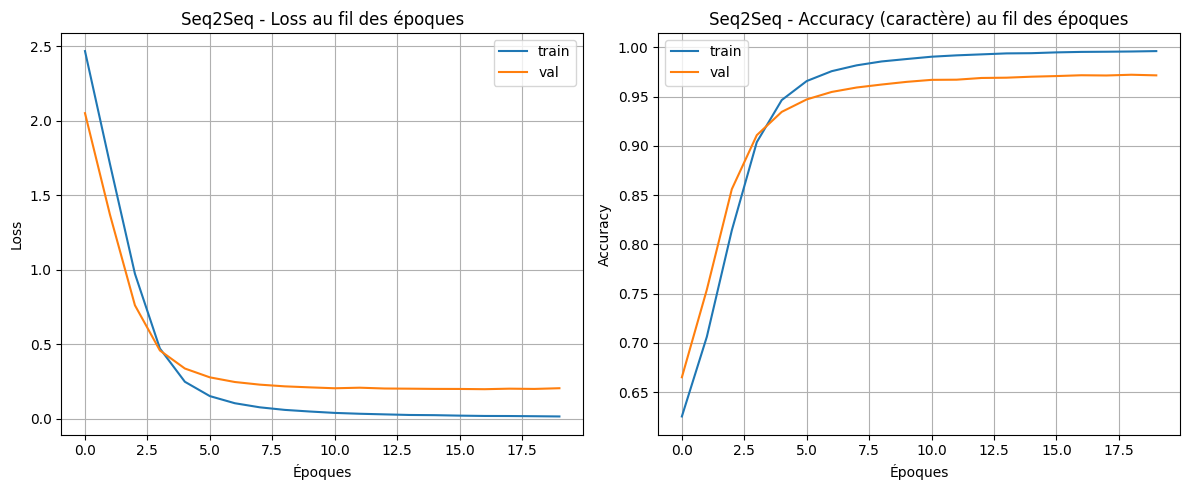

In [ ]:
# Utilisation
plot_seq2seq_learning_curves(history, save_path="/content/drive/MyDrive/Machine_Learning_-Generation_Task-_-_Romanized_Taigi_to_Hanzi/courbes_apprentissage.png")

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, type(layer))


0 encoder_inputs <class 'keras.src.layers.core.input_layer.InputLayer'>
1 decoder_inputs <class 'keras.src.layers.core.input_layer.InputLayer'>
2 embedding <class 'keras.src.layers.core.embedding.Embedding'>
3 embedding_1 <class 'keras.src.layers.core.embedding.Embedding'>
4 lstm <class 'keras.src.layers.rnn.lstm.LSTM'>
5 lstm_1 <class 'keras.src.layers.rnn.lstm.LSTM'>
6 attention <class 'keras.src.layers.attention.additive_attention.AdditiveAttention'>
7 concatenate <class 'keras.src.layers.merging.concatenate.Concatenate'>
8 time_distributed <class 'keras.src.layers.rnn.time_distributed.TimeDistributed'>


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# ---- ENCODER ----
encoder_inputs = model.input[0]
encoder_embedding = model.get_layer("embedding")
encoder_lstm = model.get_layer("lstm")

enc_emb = encoder_embedding(encoder_inputs)
encoder_outputs, state_h_enc, state_c_enc = encoder_lstm(enc_emb)

encoder_model = Model(
    inputs=encoder_inputs,
    outputs=[encoder_outputs, state_h_enc, state_c_enc],
    name="encoder_model"
)

# ---- DECODER ----
decoder_inputs = model.input[1]
decoder_embedding = model.get_layer("embedding_1")
decoder_lstm = model.get_layer("lstm_1")
attention = model.get_layer("attention")
concat = model.get_layer("concatenate")
dense = model.get_layer("time_distributed")

# Entrées pour une seule étape de décodage
decoder_input_t = Input(shape=(1,), name="decoder_input_t")
encoder_outputs_input = Input(shape=(None, encoder_outputs.shape[-1]), name="encoder_outputs")
state_h_input = Input(shape=(decoder_lstm.units,), name="state_h")
state_c_input = Input(shape=(decoder_lstm.units,), name="state_c")

# Étape de décodage
dec_emb = decoder_embedding(decoder_input_t)
decoder_out, state_h, state_c = decoder_lstm(dec_emb, initial_state=[state_h_input, state_c_input])

# Attention
attn_out = attention([decoder_out, encoder_outputs_input])
concat_out = concat([decoder_out, attn_out])

# Prédiction finale
decoder_output = dense(concat_out)

decoder_model = Model(
    inputs=[decoder_input_t, encoder_outputs_input, state_h_input, state_c_input],
    outputs=[decoder_output, state_h, state_c],
    name="decoder_model"
)


In [ ]:
# --- Décodage greedy avec attention ---
def decode_sequence_infer(input_seq, max_len=30):
    enc_outs, h, c = encoder_model.predict(input_seq)
    tok2id_j = data["tok2id_j"]
    id2tok_j = data["id2tok_j"]
    BOS, EOS = tok2id_j["<BOS>"], tok2id_j["<EOS>"]
    target_seq = np.array([[BOS]])
    decoded_tokens = []

    for _ in range(max_len):
        output, h, c = decoder_model.predict([target_seq, enc_outs, h, c])
        token_id = np.argmax(output[0, -1, :])
        if token_id == EOS:
            break
        decoded_tokens.append(id2tok_j.get(token_id, "<UNK>"))
        target_seq = np.array([[token_id]])

    return "".join(decoded_tokens)

In [ ]:
# --- Affichage sur un exemple ---
def infer_with_encoder_decoder(example_idx):
    x_input = data["X_test"][example_idx:example_idx+1]
    gold_ids = data["y_test"][example_idx]
    pad_id = data["tok2id_j"]["<PAD>"]
    r_tok = [data["id2tok_r"][i] for i in x_input[0] if i != data["tok2id_r"]["<PAD>"]]
    j_gold = [data["id2tok_j"][i] for i in gold_ids if i not in (pad_id, data["tok2id_j"]["<BOS>"], data["tok2id_j"]["<EOS>"])]
    j_pred = decode_sequence_infer(x_input)
    print("🔤 Romanisé :", " ".join(r_tok))
    print("✅ Réel     :", "".join(j_gold))
    print("🤖 Prédit   :", j_pred)

# Exemple
infer_with_encoder_decoder(0)
infer_with_encoder_decoder(1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
🔤 Romanisé : in1ui7 u7 po3tsua2 thang1 khuann3
✅ Réel     : 因為有報紙通看
🤖 Prédit   : 因為有報紙通看
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/st

In [ ]:
!pip install jiwer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 73.4 MB/s eta 0:00:00


In [ ]:
# --- Évaluation globale : CER (Character Error Rate) et BLEU ---
from jiwer import cer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


def evaluate_model_on_test(data, max_examples=200):
    pad_id = data["tok2id_j"]["<PAD>"]
    bos_id = data["tok2id_j"]["<BOS>"]
    eos_id = data["tok2id_j"]["<EOS>"]
    id2tok_j = data["id2tok_j"]

    cer_scores = []
    bleu_scores = []
    smoothie = SmoothingFunction().method4

    for i in range(min(max_examples, len(data["X_test"]))):
        x_input = data["X_test"][i:i+1]
        gold_ids = data["y_test"][i]
        gold = [id2tok_j[tok] for tok in gold_ids if tok not in (pad_id, bos_id, eos_id)]
        pred = list(decode_sequence_infer(x_input))

        ref_str = "".join(gold)
        hyp_str = "".join(pred)

        cer_scores.append(cer(ref_str, hyp_str))
        bleu_scores.append(sentence_bleu([gold], pred, smoothing_function=smoothie))

    avg_cer = np.mean(cer_scores)
    avg_bleu = np.mean(bleu_scores)

    print(f"📏 CER moyen  : {avg_cer:.4f} ({avg_cer * 100:.2f}%)")
    print(f"🟦 BLEU moyen : {avg_bleu:.4f}")
    return avg_cer, avg_bleu

# Évaluation
evaluate_model_on_test(data, max_examples=200)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1

(np.float64(0.15623608055542698), np.float64(0.8175791436549877))

In [ ]:
# --- Phase 7 : Baseline simple par lookup mot-à-mot ---
def build_lookup_table(data):
    table = {}
    for x_seq, y_seq in zip(data["X_train"], data["y_train"]):
        for x_id, y_id in zip(x_seq, y_seq[1:]):  # y_seq[1:] pour ignorer BOS
            if x_id == data["tok2id_r"]["<PAD>"] or y_id in (
                data["tok2id_j"]["<PAD>"], data["tok2id_j"]["<EOS>"]):
                continue
            if x_id not in table:
                table[x_id] = Counter()
            table[x_id][y_id] += 1
    return {x: counter.most_common(1)[0][0] for x, counter in table.items()}


def lookup_baseline_predict(x_seq, lookup_table, unk_id):
    return [lookup_table.get(tok, unk_id) for tok in x_seq if tok != 0]


def evaluate_lookup_baseline(data, max_examples=200):
    id2tok_j = data["id2tok_j"]
    pad_id = data["tok2id_j"]["<PAD>"]
    bos_id = data["tok2id_j"]["<BOS>"]
    eos_id = data["tok2id_j"]["<EOS>"]
    unk_id = data["tok2id_j"]["<UNK>"]

    table = build_lookup_table(data)

    cer_scores = []
    bleu_scores = []
    smoothie = SmoothingFunction().method4

    for i in range(min(max_examples, len(data["X_test"]))):
        x_seq = data["X_test"][i]
        y_gold_ids = data["y_test"][i]

        gold = [id2tok_j[i] for i in y_gold_ids if i not in (pad_id, bos_id, eos_id)]
        pred_ids = lookup_baseline_predict(x_seq, table, unk_id)
        pred = [id2tok_j.get(i, "<UNK>") for i in pred_ids]

        cer_scores.append(cer("".join(gold), "".join(pred)))
        bleu_scores.append(sentence_bleu([gold], pred, smoothing_function=smoothie))

    avg_cer = np.mean(cer_scores)
    avg_bleu = np.mean(bleu_scores)

    print(f"🔁 Baseline CER  : {avg_cer:.4f} ({avg_cer * 100:.2f}%)")
    print(f"🔁 Baseline BLEU : {avg_bleu:.4f}")
    return avg_cer, avg_bleu

# Évaluer la baseline
evaluate_lookup_baseline(data, max_examples=200)

🔁 Baseline CER  : 0.5673 (56.73%)
🔁 Baseline BLEU : 0.1319


(np.float64(0.5673172748936871), np.float64(0.13192386675249979))

In [27]:
# --- Phase 8 : Modèle autoregressif simplifié (LSTM unidirectionnel) ---
def build_autoregressive_model(vocab_size, embedding_dim=128, rnn_units=256, maxlen_input=30):
    model = keras.Sequential([
        layers.Input(shape=(maxlen_input,), name="input_seq"),
        layers.Embedding(vocab_size, embedding_dim),
        layers.LSTM(rnn_units, return_sequences=True),
        layers.TimeDistributed(layers.Dense(vocab_size, activation="softmax"))
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Préparation des données autoregressives (X = sinogrammes[:-1], y = sinogrammes[1:])
def prepare_autoregressive_data(data):
    Y = data["y_train"]
    X_auto = Y[:, :-1]
    y_auto = Y[:, 1:]
    return X_auto, y_auto

X_auto, y_auto = prepare_autoregressive_data(data)

# Modèle
vocab_size_j = len(data["tok2id_j"])
auto_model = build_autoregressive_model(vocab_size=vocab_size_j, maxlen_input=X_auto.shape[1])

# Entraînement
history_auto = auto_model.fit(
    X_auto, y_auto,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)

Epoch 1/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.5865 - loss: 3.0377 - val_accuracy: 0.6232 - val_loss: 2.4007
Epoch 2/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.6329 - loss: 2.3081 - val_accuracy: 0.6536 - val_loss: 2.1110
Epoch 3/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.6592 - loss: 2.0332 - val_accuracy: 0.6697 - val_loss: 1.9399
Epoch 4/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.6766 - loss: 1.8539 - val_accuracy: 0.6812 - val_loss: 1.8246
Epoch 5/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.6901 - loss: 1.7194 - val_accuracy: 0.6892 - val_loss: 1.7418
Epoch 6/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.7015 - loss: 1.6149 - val_accuracy: 0.6979 - val_loss: 1.6724
Epoch 7/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.7138 - loss: 1.5220 - val_accuracy: 0.7054 - val_loss: 1.6131
Epoch 8/20
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.7234 -

In [28]:
auto_model.save("/content/drive/MyDrive/Machine_Learning_-Generation_Task-_-_Romanized_Taigi_to_Hanzi/unidirectionnal_lstm_autoregressive_model.keras")


In [29]:
# --- Visualisation des courbes d'apprentissage pour le modèle autoregressif ---
def plot_autoregressive_learning_curves(history, save_path=None):
    plt.figure(figsize=(12, 5))

    # Sous-plot 1 : loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title("Autoregressif - Loss au fil des époques")
    plt.xlabel("Époques")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Sous-plot 2 : accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title("Autoregressif - Accuracy au fil des époques")
    plt.xlabel("Époques")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()


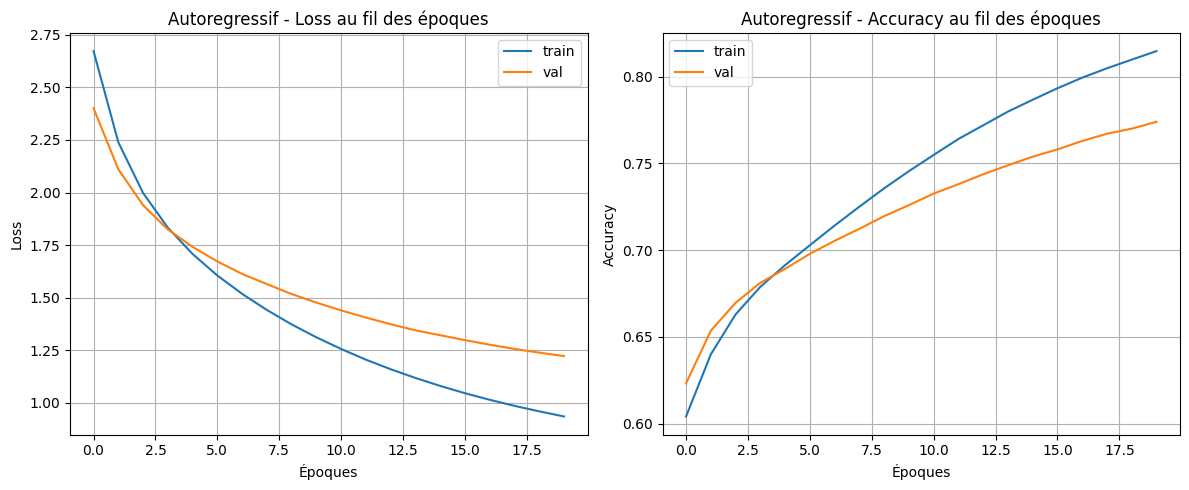

In [30]:
# Utilisation
plot_autoregressive_learning_curves(history_auto, save_path="/content/drive/MyDrive/Machine_Learning_-Generation_Task-_-_Romanized_Taigi_to_Hanzi/courbes_apprentissage_autoregressif_lstm.png")

In [31]:

# Exemple d'inférence (auto-génération à partir du BOS)
def generate_from_bos(model, tok2id, id2tok, maxlen=30):
    BOS = tok2id["<BOS>"]
    EOS = tok2id["<EOS>"]
    PAD = tok2id["<PAD>"]

    input_seq = [BOS]
    for _ in range(maxlen):
        padded = pad_sequences([input_seq], maxlen=maxlen, padding="post", value=PAD)
        preds = model.predict(padded, verbose=0)
        next_id = np.argmax(preds[0, len(input_seq)-1])
        if next_id == EOS:
            break
        input_seq.append(next_id)

    return "".join(id2tok[i] for i in input_seq[1:] if i != PAD)

# Exemple
print("🌀 Exemple génération autoregressive:")
print(generate_from_bos(auto_model, data["tok2id_j"], data["id2tok_j"]))

🌀 Exemple génération autoregressive:
我的護照號碼是五四九五九五二五


In [32]:
def plot_comparative_learning_curves(history_seq2seq, history_auto, save_path=None):
    plt.figure(figsize=(14, 5))

    # === Perte (loss)
    plt.subplot(1, 2, 1)
    plt.plot(history_seq2seq.history["loss"], label="Seq2Seq - train", color="blue")
    plt.plot(history_seq2seq.history["val_loss"], label="Seq2Seq - val", color="blue", linestyle="--")
    plt.plot(history_auto.history["loss"], label="AutoReg - train", color="green")
    plt.plot(history_auto.history["val_loss"], label="AutoReg - val", color="green", linestyle="--")
    plt.title("Courbes de perte (Loss)")
    plt.xlabel("Époques")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # === Précision (accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(history_seq2seq.history["accuracy"], label="Seq2Seq - train", color="blue")
    plt.plot(history_seq2seq.history["val_accuracy"], label="Seq2Seq - val", color="blue", linestyle="--")
    plt.plot(history_auto.history["accuracy"], label="AutoReg - train", color="green")
    plt.plot(history_auto.history["val_accuracy"], label="AutoReg - val", color="green", linestyle="--")
    plt.title("Accuracy caractère par caractère")
    plt.xlabel("Époques")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

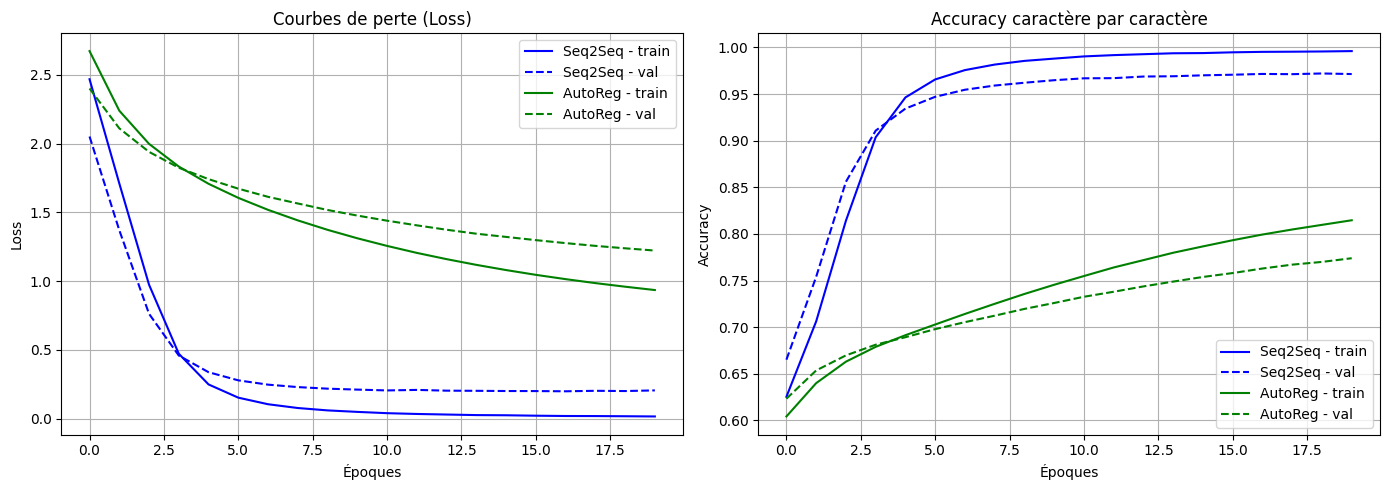

In [33]:
# Tracer les courbes d'entraînement
plot_comparative_learning_curves(history, history_auto, save_path="/content/drive/MyDrive/Machine_Learning_-Generation_Task-_-_Romanized_Taigi_to_Hanzi/comparaison_courbes_apprentissage.png")